In [133]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from PIL import Image

In [134]:
# Load MNIST dataset by torchvision.dataset
# mnist_train = datasets.MNIST('data/', train=True, download=True)  # 60000
# mnist_test = datasets.MNIST('data/', train=False, download=True)  # 10000

In [145]:
# Load MNIST dataset by mnist.npz
import numpy as np
# mnist = np.load('data/mnist.npz')  # [i for i in mnist.keys()]
# print("mnist keys: ", [i for i in mnist.keys()])  # ['x_test', 'x_train', 'y_train', 'y_test']
with np.load('data/fashion-mnist.npz') as data:
    train_examples = data['x_train']/255.  # shape = (60000, 28, 28)
    train_labels = data['y_train']  # shape = (60000, )
    test_examples = data['x_test']/255.  # shape = (10000, 28, 28)
    test_labels = data['y_test']  # shape = (10000, )

In [146]:
# 데이터셋을 Normal(0-7) / Abnormal(8-9) 로 새로 구성
train_normal_index = (train_labels<=8)
train_abnormal_index = (train_labels>=9)

test_normal_index = (test_labels<=8)
test_abnormal_index = (test_labels>=9)

In [147]:
# 데이터셋이 0-1 사이의 값인지 / 0-255 사이의 값인지 확인
np.histogram(train_examples)

(array([25790964,  1344502,  1582733,  1643562,  1876736,  2131629,
         2510093,  3303752,  4306392,  2549637]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [148]:
# MNIST Normalization
mnist_mean = train_examples.mean()
mnist_std = train_examples.std()
print("mean: {}, std: {}".format(mnist_mean, mnist_std))

mean: 0.2860405969887955, std: 0.35302424451492237


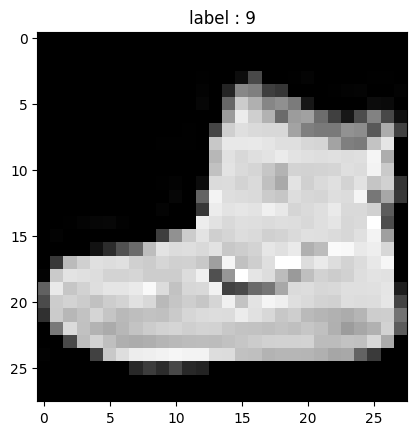

In [149]:
# Visualize MNIST sample
plt.imshow(train_examples[0], cmap='gray')
plt.title('label : %s' % train_labels[0])
plt.show()

In [150]:
# Configs
BATCH_SIZE = 32
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.2
EPOCHS = 5
LATENT_DIM = 32

In [151]:
# Pytorch Dataset
from torch.utils.data import Dataset

class FashionMnistDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [152]:
num_train_normal = train_normal_index.sum()
num_train_abnormal = train_abnormal_index.sum()
num_test_normal = test_normal_index.sum()
num_test_abnormal = test_abnormal_index.sum()

train_normal = train_examples[train_normal_index] # shape = [60000, 28, 28]
train_abnormal = train_examples[train_abnormal_index]
test_normal = test_examples[test_normal_index]
test_abnormal = test_examples[test_abnormal_index]

In [153]:
print(num_train_abnormal)
print(num_train_normal)

6000
54000


In [154]:
# Train MNIST dataset

train_transform = transforms.Compose([
    # transforms.RandomSizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[mnist_mean], std=[mnist_std]),

    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[mnist_mean], std=[mnist_std]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])


train_normal_dataset = FashionMnistDataset(train_normal, np.ones(num_train_normal), transform=train_transform)
test_normal_dataset = FashionMnistDataset(test_normal, np.ones(num_test_normal), transform=test_transform)

train_abnormal_dataset = FashionMnistDataset(train_abnormal, np.zeros(num_train_abnormal), transform=train_transform)
test_abnormal_dataset = FashionMnistDataset(test_abnormal, np.zeros(num_test_abnormal), transform=test_transform)



train_normal_loader = torch.utils.data.DataLoader(dataset=train_normal_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_normal_loader = torch.utils.data.DataLoader(dataset=test_normal_dataset,
                                                 batch_size=1, shuffle=False, num_workers=2)
train_abnormal_loader = torch.utils.data.DataLoader(dataset=train_abnormal_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_abnormal_loader = torch.utils.data.DataLoader(dataset=test_abnormal_dataset,
                                                 batch_size=1, shuffle=False, num_workers=2)

In [155]:
class FashionMnistAutoEncoder(torch.nn.Module):
    def __init__(self, input_size=(28, 28), num_classes=10, dropout_late=0.2):
        super(FashionMnistAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.BatchNorm1d(28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [156]:
model = FashionMnistAutoEncoder(dropout_late=DROPOUT_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [157]:
model.train()

FashionMnistAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
  )
)

In [158]:
for epoch in range(EPOCHS):
    model.train()
    for i, (image, _) in enumerate(train_normal_loader):
        x = image.view(-1, 28*28)
        x = x  # /255.

        optimizer.zero_grad()
        pred = model(x)

        loss = criterion(pred, x)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Epoch {}/{} || Train Step : {} || Loss : {:3f}".format(epoch, EPOCHS, i, loss.item()))

Epoch 0/5 || Train Step : 0 || Loss : 0.206652
Epoch 0/5 || Train Step : 1000 || Loss : 0.020538
Epoch 1/5 || Train Step : 0 || Loss : 0.026026
Epoch 1/5 || Train Step : 1000 || Loss : 0.023118
Epoch 2/5 || Train Step : 0 || Loss : 0.020257
Epoch 2/5 || Train Step : 1000 || Loss : 0.019646
Epoch 3/5 || Train Step : 0 || Loss : 0.015778
Epoch 3/5 || Train Step : 1000 || Loss : 0.016167
Epoch 4/5 || Train Step : 0 || Loss : 0.012618
Epoch 4/5 || Train Step : 1000 || Loss : 0.017264


In [159]:
# Get Threshold
train_normal_loss = []
train_abnormal_loss = []

model.eval()

for i, (image, _) in enumerate(train_normal_loader):
    if i == len(train_normal_loader):
        break
    x = image.view(-1, 28*28) # / 255.
    pred = model(x)

    loss = criterion(pred, x)
    train_normal_loss.append(loss.item())

for i, (image, _) in enumerate(train_abnormal_loader):
    x = image.view(-1, 28*28) # / 255.
    pred = model(x)

    loss = criterion(pred, x)
    train_abnormal_loss.append(loss.item())

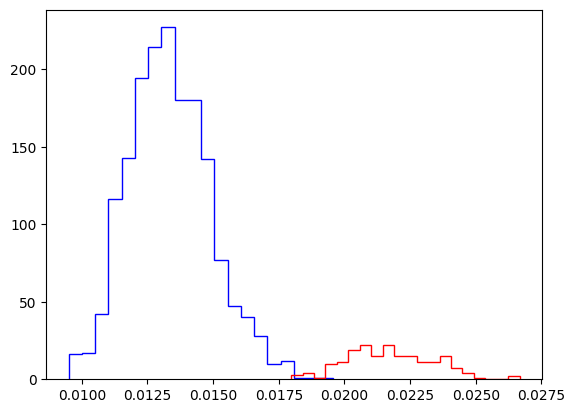

In [161]:
# 임계값 찾기
plt.figure()
plt.hist(train_normal_loss, bins=20, color='b', histtype='step')
plt.hist(train_abnormal_loss, bins=20, color='r', histtype='step')
plt.show()
threshold = 0.018

In [163]:
# Normal = 1 / Abnormal = 0
test_preds = []
test_labels = []

test_normal_loss = []
test_abnormal_loss = []

model.eval()

for i, (image, label) in enumerate(test_normal_loader):

    x = image.view(-1, 28*28)
    pred = model(x)

    loss = criterion(pred, x)
    test_preds.append(loss.item())
    test_labels.append(label.item())
    test_normal_loss.append(loss.item())

for i, (image, label) in enumerate(test_abnormal_loader):

    x = image.view(-1, 28*28)
    pred = model(x)

    loss = criterion(pred, x)
    test_preds.append(loss.item())
    test_labels.append(label.item())
    test_abnormal_loss.append(loss.item())


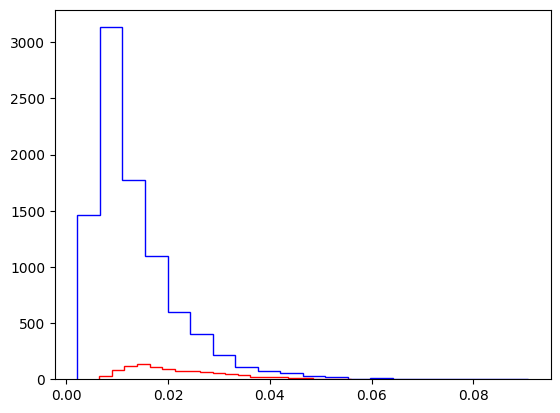

In [164]:
# 임계값 찾기
plt.figure()
plt.hist(test_normal_loss, bins=20, color='b', histtype='step')
plt.hist(test_abnormal_loss, bins=20, color='r', histtype='step')
plt.show()
# threshold = 2.7 * 1e-6

In [165]:
preds = np.array(test_preds) < threshold
preds = preds.astype(int)
labels = np.array(test_labels).astype(int)

In [166]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [167]:
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

Accuracy 0.7586
Precision 0.2214342001576044
Recall 0.562
